In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import os
import pandas as pd
import albumentations as A
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Flatten

# from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [4]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())


True


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12129140585940681247
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14343274496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15458117146260153530
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [6]:
driver_path='/content/drive/MyDrive/Colab Notebooks/'
num_classes=5
root_path=driver_path+'Data/Sport Images/'
ori_data={}
image_sports=[]
X_train=[]
y_train=[]
class_num=0

for folder in os.listdir(root_path):
  if folder!='Image URLs':
    image_sports.append(folder)
    for file in os.listdir(root_path+folder):
      if not file.startswith(".ipynb_checkpoints") and os.path.splitext(file)[1] not in ['.txt','.gif']:
        path=root_path+folder+'/'+file
        img = cv2.imread(path)
        X_train.append(img)

        label=[0]*num_classes
        label[class_num]=1
        y_train.append(label)

    class_num+=1 

In [7]:
train_size=len(X_train)
for i in range(train_size):
  img=X_train[i]
  compose = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=0.5, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0, rotate_limit=0, p=0.5), # translate
    A.RandomCrop(height=min(img.shape[0],img.shape[1]), width=min(img.shape[0],img.shape[1]),p=0.5), 
    # A.RandomScale(scale_limit=(0.25, 0.5),p=0.5), # randomly zoom
  ])
  composed = compose(image=img)
  new_image = composed['image']
  X_train.append(new_image)
  y_train.append(y_train[i])


for i in range(len(X_train)):
  X_train[i]=cv2.resize(X_train[i],(256,256))

X_train=np.stack(X_train,axis=0)
y_train=np.stack(y_train,axis=0)

In [8]:
driver_path='/content/drive/MyDrive/Colab Notebooks/'
root_path=driver_path+'Data/Sport Videos/'
videos=[]
labels=[]
class_num=0

mappingtable={'baseball':'BaseballPitch','basketball':'Basketball','fencing':'Fencing','tennis':'TennisSwing','volleyball':'VolleyballSpiking'}
video_sports=[mappingtable[sport] for sport in image_sports]

for folder in video_sports:
  for file in os.listdir(root_path+folder): 
    if not file.startswith(".ipynb_checkpoints"):# and os.path.splitext(file)[1] not in ['.avi']:
      video_frames=[]
      path=root_path+folder+'/'+file
      # Open the video file
      video = cv2.VideoCapture(path)

      # Get the total number of frames in the video
      # total_frames = min(int(video.get(cv2.CAP_PROP_FRAME_COUNT)),100)
      total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
      # Calculate the interval between frames
      frame_interval = (total_frames-1) / 99

      # Set the current frame to the first frame in the video
      current_frame = 0

      # Loop through the frames and extract frames at the desired interval
      for i in range(100):
        # Set the video's current frame to the desired frame
        video.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
        
        # Read the frame
        ret, frame = video.read()
        
        if frame is None:
          break
        # Write the frame to the output folder
        frame=cv2.resize(frame,(256,256))

        video_frames.append(frame)
        current_frame += frame_interval
      # Release the video file
      video.release()

      video_frames=np.stack(video_frames,axis=0)
      videos.append(video_frames)

      label=[0]*num_classes
      label[class_num]=1
      labels.append(label)
  class_num+=1

true_label_test=np.argmax(labels, axis=1)                  

In [9]:
def train_model(base_model,batch_size,epochs,root_path):
  for layer in base_model.layers:
    layer.trainable = False
      
  print(f'Model {base_model.name} begins training!')
  # Define the model architecture
  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(num_classes, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

  # Define callbacks for early stopping and saving the best weights
  early_stopping = EarlyStopping(monitor='loss', patience=1000)
  model_checkpoint = ModelCheckpoint(filepath=root_path+f"Video_{base_model.name}.h5", monitor='loss', save_best_only=True, save_weights_only=True)


  # Train the model with early stopping and saving the best weights
  history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, model_checkpoint],workers=16)

def test_model(name,root_path,videos):
  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(num_classes, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation='softmax'))

  model.load_weights(root_path+f'Image_{name}.h5')
  # Make predictions on the test data
  pred_label_test=[]
  for X_test in videos:
    y_pred = model.predict(X_test)
    class_prob=np.average(y_pred, axis=0)
    pred_label_test.append(np.argmax(class_prob))

  return np.array(pred_label_test)

def show_scores(true_label_test,pred_label_test,name,sports):
  # calculate the confusion matrix
  cm = confusion_matrix(true_label_test, pred_label_test)
  # calculate the accuracy
  accuracy = accuracy_score(true_label_test, pred_label_test)
  # calculate the precision
  precision = precision_score(true_label_test, pred_label_test, average='weighted')
  # calculate the recall
  recall = recall_score(true_label_test, pred_label_test, average='weighted')
  # calculate the F1 score
  f1 = f1_score(true_label_test, pred_label_test, average='weighted')

  fig, ax = plt.subplots(figsize=(20,7))

  ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sports).plot(ax=ax)
  ax.set_title(f'Confusion Matrix of {name} on Video Data Set')

  plt.show()

  print(f'The scores of {name}:\n')
  scores=pd.DataFrame({'Precision':precision,'Recall':recall,'Accuracy':accuracy,'F1 Score':f1},index=['Video Data'])
  print(scores)

94765736/94765736 [==============================] - 3s 0us/step
Model resnet50 begins training!
Epoch 1/53
26/26 [==============================] - 47s 1s/step - loss: 1.0087 - accuracy: 0.6609
Epoch 2/53
26/26 [==============================] - 23s 883ms/step - loss: 0.7750 - accuracy: 0.7905
Epoch 3/53
26/26 [==============================] - 23s 891ms/step - loss: 0.6859 - accuracy: 0.8238
Epoch 4/53
26/26 [==============================] - 23s 899ms/step - loss: 0.6022 - accuracy: 0.8518
Epoch 5/53
26/26 [==============================] - 24s 911ms/step - loss: 0.5471 - accuracy: 0.8573
Epoch 6/53
26/26 [==============================] - 23s 900ms/step - loss: 0.4996 - accuracy: 0.8739
Epoch 7/53
26/26 [==============================] - 23s 900ms/step - loss: 0.4412 - accuracy: 0.8930
Epoch 8/53
26/26 [==============================] - 23s 902ms/step - loss: 0.4073 - accuracy: 0.9024
Epoch 9/53
26/26 [==============================] - 23s 902ms/step - loss: 0.3946 - accuracy: 0.89

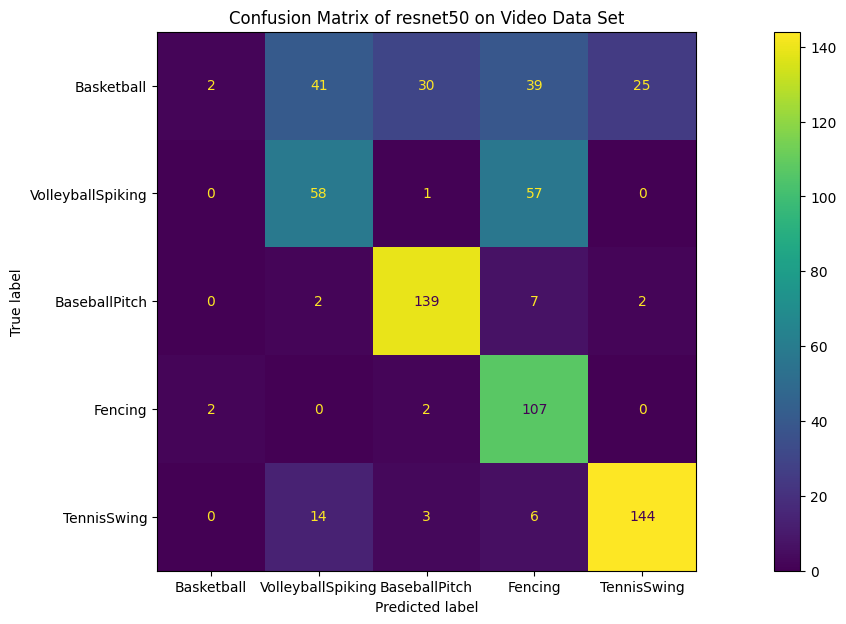

The scores of resnet50:

            Precision    Recall  Accuracy  F1 Score
Video Data     0.6487  0.660793  0.660793  0.595277


In [10]:
base_model=ResNet50(weights='imagenet',include_top=False, input_shape=X_train.shape[1:], classes=num_classes)
train_model(base_model,256,53,driver_path)

pred_label_test=test_model(base_model.name,driver_path,videos)
show_scores(true_label_test,pred_label_test,base_model.name,video_sports)

16705208/16705208 [==============================] - 1s 0us/step
Model efficientnetb0 begins training!
Epoch 1/41
26/26 [==============================] - 22s 560ms/step - loss: 1.0932 - accuracy: 0.6063
Epoch 2/41
26/26 [==============================] - 15s 574ms/step - loss: 0.8676 - accuracy: 0.6892
Epoch 3/41
26/26 [==============================] - 15s 578ms/step - loss: 0.7652 - accuracy: 0.7441
Epoch 4/41
26/26 [==============================] - 15s 578ms/step - loss: 0.6725 - accuracy: 0.7988
Epoch 5/41
26/26 [==============================] - 15s 580ms/step - loss: 0.6198 - accuracy: 0.8215
Epoch 6/41
26/26 [==============================] - 16s 601ms/step - loss: 0.5590 - accuracy: 0.8572
Epoch 7/41
26/26 [==============================] - 15s 578ms/step - loss: 0.5170 - accuracy: 0.8702
Epoch 8/41
26/26 [==============================] - 15s 583ms/step - loss: 0.4824 - accuracy: 0.8791
Epoch 9/41
26/26 [==============================] - 15s 578ms/step - loss: 0.4389 - accur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


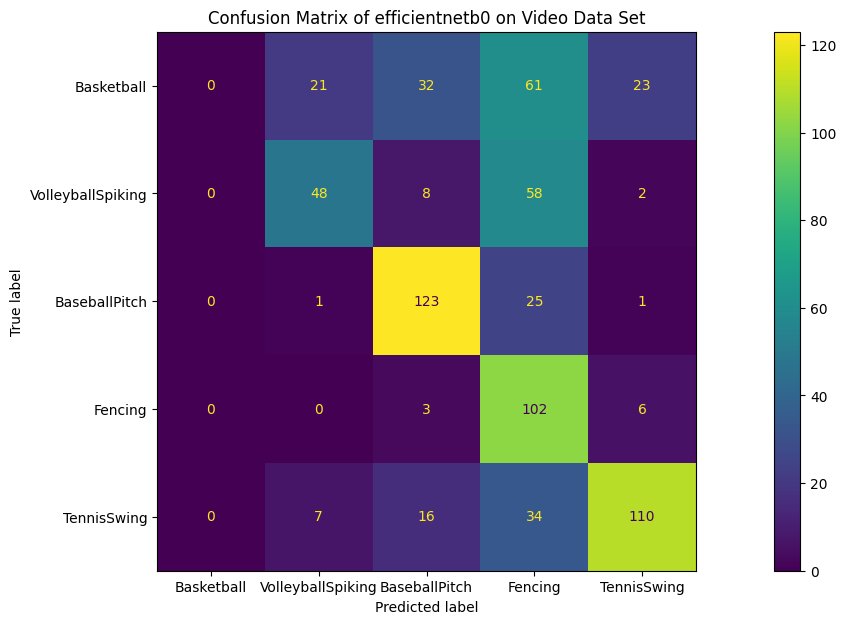

The scores of efficientnetb0:

            Precision    Recall  Accuracy  F1 Score
Video Data   0.504387  0.562408  0.562408  0.507572


In [11]:
base_model=EfficientNetB0(weights='imagenet',include_top=False, input_shape=X_train.shape[1:], classes=num_classes)
train_model(base_model,256,41,driver_path)

pred_label_test=test_model(base_model.name,driver_path,videos)
show_scores(true_label_test,pred_label_test,base_model.name,video_sports)

58889256/58889256 [==============================] - 2s 0us/step
Model vgg16 begins training!
Epoch 1/21
102/102 [==============================] - 53s 412ms/step - loss: 1.0733 - accuracy: 0.6178
Epoch 2/21
102/102 [==============================] - 33s 320ms/step - loss: 0.7194 - accuracy: 0.7905
Epoch 3/21
102/102 [==============================] - 33s 325ms/step - loss: 0.5528 - accuracy: 0.8508
Epoch 4/21
102/102 [==============================] - 33s 326ms/step - loss: 0.4444 - accuracy: 0.8725
Epoch 5/21
102/102 [==============================] - 33s 324ms/step - loss: 0.3800 - accuracy: 0.8917
Epoch 6/21
102/102 [==============================] - 33s 324ms/step - loss: 0.3354 - accuracy: 0.9050
Epoch 7/21
102/102 [==============================] - 33s 326ms/step - loss: 0.3084 - accuracy: 0.9125
Epoch 8/21
102/102 [==============================] - 34s 330ms/step - loss: 0.2839 - accuracy: 0.9134
Epoch 9/21
102/102 [==============================] - 32s 317ms/step - loss: 0.285

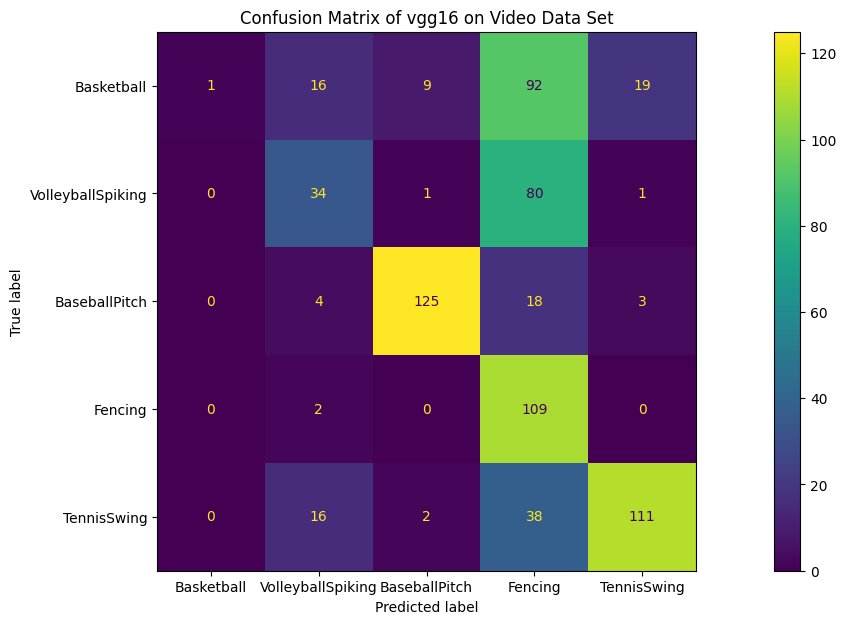

The scores of vgg16:

            Precision    Recall  Accuracy  F1 Score
Video Data   0.738439  0.558003  0.558003  0.516575


In [12]:
base_model=VGG16(weights='imagenet',include_top=False, input_shape=X_train.shape[1:], classes=num_classes)
train_model(base_model,64,21,driver_path)

pred_label_test=test_model(base_model.name,driver_path,videos)
show_scores(true_label_test,pred_label_test,base_model.name,video_sports)